In [4]:
%load_ext autoreload
%autoreload 2

In [1]:
import pickle
import numpy as np
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

try:
    import cartopy.crs as ccrs
except:
    print("Could not load cartopy.")
    ccrs = None
from matplotlib.lines import Line2D
from tools import *
from settings import *
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from os.path import join
BASEPATH = "/home/lisajsch/notebooks/Plenum/"

In [3]:
poles = {
    "IceCube": {
        "lon": 1 * u.deg,
        "lat": -90 * u.deg,
        "color": "k",
        "ls": "-",
        "label": "IceCube",
        "marker": "d",
    },
    "Gen-2": {
        "lon": 1 * u.deg,
        "lat": -90 * u.deg,
        "color": "gray",
        "ls": "-.",
        "label": "IceCube x 7.5",
        "marker": "d",
    },
    "P-ONE": {
        "lon": -123.3656 * u.deg,
        "lat": 48.4284 * u.deg,
        "color": "#a50000",
        "ls": "--",
        "label": "at P-ONE location",
        "marker": "v",
    },
    "KM3NeT": {
        "lon": (16 + 6 / 60) * u.deg,
        "lat": (36 + 16 / 60) * u.deg,
        "color": colors[0],
        "ls": "--",
        "label": "at KM3NeT location",
        "marker": "d",
    },
    "Baikal-GVD": {
        "lon": 108.1650 * u.deg,
        "lat": 53.5587 * u.deg,
        "color": colors[1],
        "ls": "--",
        "label": "at GVD location",
        "marker": "d",
    },
    "Plenum-1": {"color": "#339999", "ls": "-", "label": r"PLE$\nu$M-1", "marker": "s"},
    "Plenum-2": {
        "color": "#a50000",
        "ls": "-.",
        "label": r"PLE$\nu$M-2",
        "marker": "o",
    },
}

### Cartopy

🌍


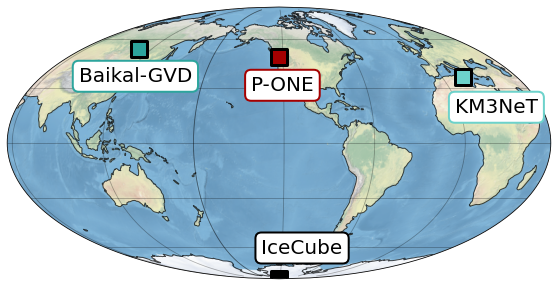

In [33]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(
    projection=ccrs.Mollweide(central_longitude=poles["P-ONE"]["lon"].value)
)
ax.set_global()
ax.stock_img()
ax.coastlines(color="k", alpha=0.7)
gl = ax.gridlines(draw_labels=False, alpha=0.3, color="k")
edc = "k"
for i, (name, new_pole) in enumerate(sorted(poles.items())):
    if "Plenum" in name or "Gen" in name:
        continue
    ax.scatter(
        np.degrees(new_pole["lon"]),
        np.degrees(new_pole["lat"]),
        s=230,
        alpha=1,
        marker="s",
        c=[new_pole["color"]],
        edgecolors=edc,
        lw=3,
        label=name,
        transform=ccrs.PlateCarree(),
        zorder=10,
    )
    if name=="IceCube": continue
    ax.text(
        x=new_pole["lon"].value - 20,
        y=new_pole["lat"].value - 20,
        s=name,
        transform=ccrs.PlateCarree(),
        fontsize=20,
        bbox=dict(boxstyle="round", fc="w", linewidth=2, ec=new_pole["color"])
    )
ax.text(
    x=poles["P-ONE"]["lon"].value - 20,
    y=-65,
    s="IceCube",
    transform=ccrs.PlateCarree(),
    fontsize=20,
    bbox=dict(boxstyle="round", fc="w", linewidth=2, ec=poles["IceCube"]["color"])
)
plt.savefig(join(BASEPATH, "plots/map_overview.pdf"))
print("\U0001F30D")


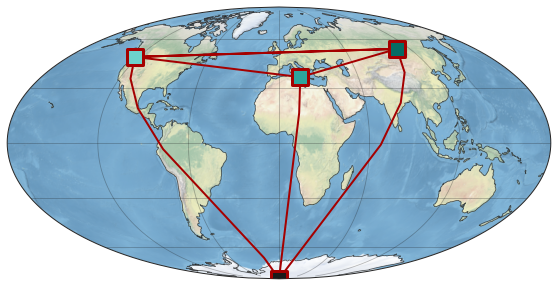

In [ ]:
if ccrs:
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(projection=ccrs.Mollweide())
    ax.set_global()
    ax.stock_img()
    ax.coastlines(color="k", alpha=0.7)
    gl = ax.gridlines(draw_labels=False, alpha=0.3, color="k")
    edc = poles["Plenum-1"]["color"]
    for i, (name, new_pole) in enumerate(sorted(poles.items())):
        if "Plenum" in name or "Gen" in name:
            continue
        ax.scatter(
            np.degrees(new_pole["lon"]),
            np.degrees(new_pole["lat"]),
            s=230,
            alpha=1,
            marker="s",
            c=[new_pole["color"]],
            edgecolors=edc,
            lw=3,
            label=name,
            transform=ccrs.PlateCarree(),
            zorder=10,
        )
    ax.plot(
        [
            poles["IceCube"]["lon"].value,
            poles["P-ONE"]["lon"].value,
            poles["Baikal-GVD"]["lon"].value,
            poles["IceCube"]["lon"].value,
            poles["KM3NeT"]["lon"].value,
            poles["P-ONE"]["lon"].value,
            poles["Baikal-GVD"]["lon"].value,
            poles["KM3NeT"]["lon"].value,
        ],
        [
            poles["IceCube"]["lat"].value,
            poles["P-ONE"]["lat"].value,
            poles["Baikal-GVD"]["lat"].value,
            poles["IceCube"]["lat"].value,
            poles["KM3NeT"]["lat"].value,
            poles["P-ONE"]["lat"].value,
            poles["Baikal-GVD"]["lat"].value,
            poles["KM3NeT"]["lat"].value,
        ],
        transform=ccrs.PlateCarree(),
        color=edc,
    )
    plt.savefig("../plots/map_overview.pdf")
else:
    print("\U0001F30D")


### First, get all effective areas

In [5]:
from aeff_calculations import get_aeff_and_binnings


In [6]:
aeff_2d, log_ebins, ebins, sindec_bins, ra_bins = get_aeff_and_binnings("full")

emids = get_mids(ebins)
ewidth = np.diff(ebins)
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)
ra_mids = get_mids(ra_bins)
ra_width = np.diff(ra_bins)


## Catalogs

In [6]:
# _3FHL = np.load('../resources/3FHL_All_2019.npy')
# _4FGL = np.load('../resources/4FGL.npy')

tracks = np.load("../resources/tracks.npy")
ang_unc = np.empty(len(tracks), dtype=float)
for i, ra_err in enumerate(tracks["ra_err"]):
    name = tracks["name"][i]
    if b"HES" in name and not b"AHES" in name:
        ang_unc[i] = ra_err[0]
    else:
        Dec_err = np.mean([tracks["dec_err"][i][0], -tracks["dec_err"][i][1]])
        Ra_err = np.mean([ra_err[0], -ra_err[1]])
        ang_unc[i] = conv2ang_uncertainty(Ra_err, Dec_err, tracks["dec"][i])
tracks = np.lib.recfunctions.append_fields(
    tracks, names="sigma", data=ang_unc, dtypes=float, usemask=False
)


# Create a skymap including the ps detection efficiency and all HE tracks 

## get all detection efficiencies $\propto N_{detected}$ per fixed livetime

In [6]:
with open("../resources/detection_efficiencies.pckl", "rb") as f:
    tcks, padded_sd = pickle.load(f)


In [8]:
import seaborn as sns

matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use("../style.mplstyle")
colorlist = plt.rcParams["axes.prop_cycle"].by_key()["color"]
warnings.filterwarnings("ignore")


### detection efficiency -- IceCube only

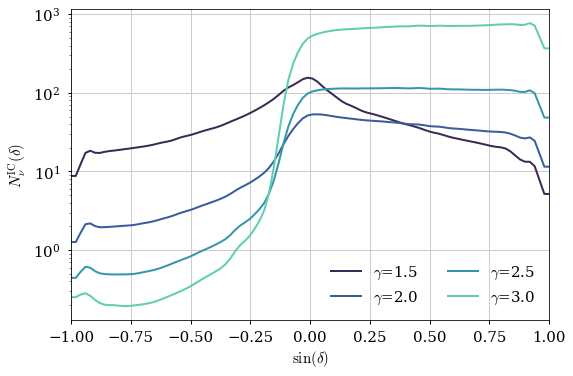

In [9]:
sindec_vals = np.linspace(-1, 1, 100)
gammas = [1.5, 2.0, 2.5, 3.0]
fig, ax = plt.subplots(figsize=(8, 6))
for gamma in gammas:
    eff = np.exp(tcks[gamma]["IceCube"](sindec_vals)) * LIVETIME * PHI_0
    p = ax.plot(sindec_vals, eff, label=r"$\gamma$={0:.1f}".format(gamma))

ax.legend(ncol=2, frameon=False, loc=4)
ax.set_xlabel(r"$\sin(\delta)$")
ax.set_ylabel(r"$N_{\nu}^{\rm IC}(\delta)$")
ax.set_yscale("log")
ax.set_xlim(-1, 1)
fig.tight_layout()
plt.subplots_adjust(top=0.85)


### all detectors -- equal contribution -- detection efficiency relative to icecube at respective declination

In [10]:
sindec_vals = np.linspace(-1, 1, 1000)


In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(10, 7))
axes = axes.flatten()
for ii, gamma in enumerate(gammas):
    ax = axes[ii]
    for det in tcks[gamma]:
        if "Gen" in det:
            continue
        Res = np.exp(tcks[gamma][det](sindec_vals)) / np.exp(
            tcks[gamma]["IceCube"](sindec_vals)
        )
        p = ax.plot(
            sindec_vals,
            Res,
            label=poles[det]["label"] if ii == 0 else "",
            color=poles[det]["color"],
            ls=poles[det]["ls"],
            lw=2,
        )
    ax.set_title(r"Spectral index $\gamma$={0:.1f}".format(gamma), fontsize="small")
    ax.axvline(np.sin(sgr_a.icrs.dec), color="k", ls=":")
    # ax.axvline(np.sin(txs0506.icrs.dec), color="k", ls=":")
    ax.set_yscale("log")
    ax.set_xlim(-1, 1)
    ax.text(0.28, 0.055, "GC", transform=ax.transAxes, fontsize="small")
    print(gamma)
    if False:
        improv_sgr = np.exp(tcks[gamma]["Plenum-1"](np.sin(sgr_a.icrs.dec))) / np.exp(
            tcks[gamma]["IceCube"](np.sin(sgr_a.icrs.dec))
        )
        improv_txs0506 = np.exp(
            tcks[gamma]["Plenum-1"](np.sin(txs0506.icrs.dec))
        ) / np.exp(tcks[gamma]["IceCube"](np.sin(txs0506.icrs.dec)))
        improv_ngc1068 = np.exp(
            tcks[gamma]["Plenum-1"](np.sin(ngc1068.icrs.dec))
        ) / np.exp(tcks[gamma]["IceCube"](np.sin(ngc1068.icrs.dec)))
        print("PLENUM-1 Improv at GC:", improv_sgr)
        print("PLENUM-1 Improv at txs0506:", improv_txs0506)
        print("PLENUM-1 Improv at ngc1068:", improv_ngc1068)

        improv_sgr = np.exp(tcks[gamma]["Plenum-2"](np.sin(sgr_a.icrs.dec))) / np.exp(
            tcks[gamma]["IceCube"](np.sin(sgr_a.icrs.dec))
        )
        improv_txs0506 = np.exp(
            tcks[gamma]["Plenum-2"](np.sin(txs0506.icrs.dec))
        ) / np.exp(tcks[gamma]["IceCube"](np.sin(txs0506.icrs.dec)))
        improv_ngc1068 = np.exp(
            tcks[gamma]["Plenum-2"](np.sin(ngc1068.icrs.dec))
        ) / np.exp(tcks[gamma]["IceCube"](np.sin(ngc1068.icrs.dec)))
        print("PLENUM-2 Improv at GC:", improv_sgr)
        print("PLENUM-2 Improv at txs0506:", improv_txs0506)
        print("PLENUM-2 Improv at ngc1068:", improv_ngc1068)

axes[2].set_xlabel(r"Declination $\sin(\delta)$")
axes[3].set_xlabel(r"Declination $\sin(\delta)$")
axes[0].set_ylabel(r"$N_{\nu}^{\rm det}(\delta) / N_{\nu}^{\rm IC}(\delta)$")
axes[2].set_ylabel(r"$N_{\nu}^{\rm det}(\delta) / N_{\nu}^{\rm IC}(\delta)$")
fig.legend(loc="upper center", ncol=3, frameon=False, fontsize="small")
fig.tight_layout()
plt.subplots_adjust(top=0.82)
fig.savefig("../plots/relative_detection_eff_dIC_vs_sindec.pdf")


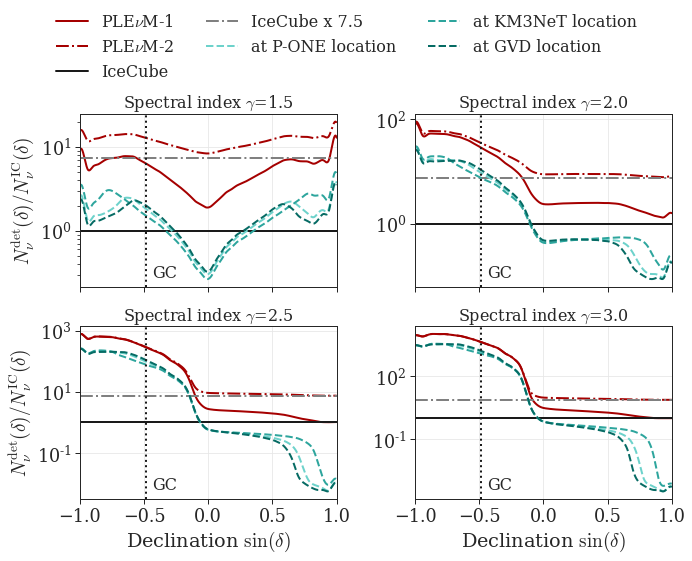

In [10]:
sindec_vals = np.linspace(-1, 1, 1000)

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(10, 8))
axes = axes.flatten()
for ii, gamma in enumerate(gammas):
    ax = axes[ii]
    for det in tcks[gamma]:
        Res = np.exp(tcks[gamma][det](sindec_vals)) / np.exp(
            tcks[gamma]["IceCube"](sindec_vals)
        )
        p = ax.plot(
            sindec_vals,
            Res,
            label=poles[det]["label"] if ii == 0 else "",
            color=poles[det]["color"],
            ls=poles[det]["ls"],
            lw=2,
        )
    ax.set_title(r"Spectral index $\gamma$={0:.1f}".format(gamma), fontsize="small")
    ax.axvline(np.sin(sgr_a.icrs.dec), color="k", ls=":")
    # ax.axvline(np.sin(txs0506.icrs.dec), color="k", ls=":")
    ax.set_yscale("log")
    ax.set_xlim(-1, 1)
    ax.text(0.28, 0.055, "GC", transform=ax.transAxes, fontsize="small")
    if False:
        print(gamma)
        improv_sgr = np.exp(tcks[gamma]["Plenum-1"](np.sin(sgr_a.icrs.dec))) / np.exp(
            tcks[gamma]["IceCube"](np.sin(sgr_a.icrs.dec))
        )
        improv_txs0506 = np.exp(
            tcks[gamma]["Plenum-1"](np.sin(txs0506.icrs.dec))
        ) / np.exp(tcks[gamma]["IceCube"](np.sin(txs0506.icrs.dec)))
        improv_ngc1068 = np.exp(
            tcks[gamma]["Plenum-1"](np.sin(ngc1068.icrs.dec))
        ) / np.exp(tcks[gamma]["IceCube"](np.sin(ngc1068.icrs.dec)))
        print("PLENUM-1 Improv at GC:", improv_sgr)
        print("PLENUM-1 Improv at txs0506:", improv_txs0506)
        print("PLENUM-1 Improv at ngc1068:", improv_ngc1068)

        improv_sgr = np.exp(tcks[gamma]["Plenum-2"](np.sin(sgr_a.icrs.dec))) / np.exp(
            tcks[gamma]["IceCube"](np.sin(sgr_a.icrs.dec))
        )
        improv_txs0506 = np.exp(
            tcks[gamma]["Plenum-2"](np.sin(txs0506.icrs.dec))
        ) / np.exp(tcks[gamma]["IceCube"](np.sin(txs0506.icrs.dec)))
        improv_ngc1068 = np.exp(
            tcks[gamma]["Plenum-2"](np.sin(ngc1068.icrs.dec))
        ) / np.exp(tcks[gamma]["IceCube"](np.sin(ngc1068.icrs.dec)))
        print("PLENUM-2 Improv at GC:", improv_sgr)
        print("PLENUM-2 Improv at txs0506:", improv_txs0506)
        print("PLENUM-2 Improv at ngc1068:", improv_ngc1068)


axes[2].set_xlabel(r"Declination $\sin(\delta)$")
axes[3].set_xlabel(r"Declination $\sin(\delta)$")
axes[0].set_ylabel(r"$N_{\nu}^{\rm det}(\delta) / N_{\nu}^{\rm IC}(\delta)$")
axes[2].set_ylabel(r"$N_{\nu}^{\rm det}(\delta) / N_{\nu}^{\rm IC}(\delta)$")
fig.legend(loc="upper center", ncol=3, frameon=False, fontsize="small")
fig.tight_layout()
plt.subplots_adjust(top=0.8)
fig.savefig("../plots/relative_detection_eff_dIC_vs_sindec_wGen2.pdf")


In [11]:
tcks[gamma].keys()


dict_keys(['Plenum-1', 'Plenum-2', 'IceCube', 'Gen-2', 'P-ONE', 'KM3NeT', 'Baikal-GVD'])

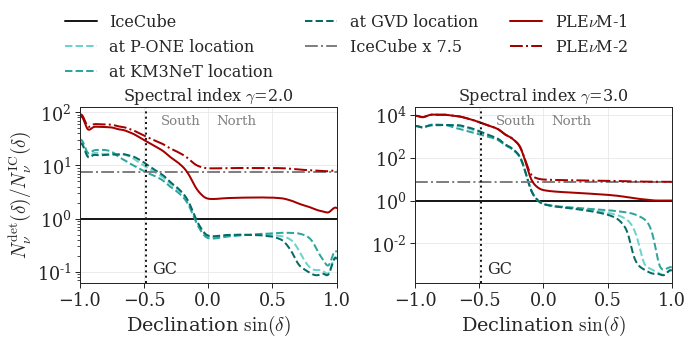

In [14]:
sindec_vals = np.linspace(-1, 1, 1000)

fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(10, 5))
axes = axes.flatten()
for ii, gamma in enumerate([2.0, 3.0]):
    ax = axes[ii]
    for det in [
        "IceCube",
        "P-ONE",
        "KM3NeT",
        "Baikal-GVD",
        "Gen-2",
        "Plenum-1",
        "Plenum-2",
    ]:  # tcks[gamma]:
        Res = np.exp(tcks[gamma][det](sindec_vals)) / np.exp(
            tcks[gamma]["IceCube"](sindec_vals)
        )
        p = ax.plot(
            sindec_vals,
            Res,
            label=poles[det]["label"] if ii == 0 else "",
            color=poles[det]["color"],
            ls=poles[det]["ls"],
            lw=2,
        )
    ax.set_title(r"Spectral index $\gamma$={0:.1f}".format(gamma), fontsize="small")
    ax.axvline(np.sin(sgr_a.icrs.dec), color="k", ls=":")
    # ax.axvline(np.sin(txs0506.icrs.dec), color="k", ls=":")
    ax.set_yscale("log")
    ax.set_xlim(-1, 1)
    ax.text(0.28, 0.055, "GC", transform=ax.transAxes, fontsize="small")
    ax.text(
        0.47,
        0.9,
        "South",
        transform=ax.transAxes,
        fontsize="x-small",
        color="gray",
        ha="right",
    )
    ax.text(
        0.53,
        0.9,
        "North",
        transform=ax.transAxes,
        fontsize="x-small",
        color="gray",
        ha="left",
    )
    if False:
        print(gamma)
        improv_sgr = np.exp(tcks[gamma]["Plenum-1"](np.sin(sgr_a.icrs.dec))) / np.exp(
            tcks[gamma]["IceCube"](np.sin(sgr_a.icrs.dec))
        )
        improv_txs0506 = np.exp(
            tcks[gamma]["Plenum-1"](np.sin(txs0506.icrs.dec))
        ) / np.exp(tcks[gamma]["IceCube"](np.sin(txs0506.icrs.dec)))
        improv_ngc1068 = np.exp(
            tcks[gamma]["Plenum-1"](np.sin(ngc1068.icrs.dec))
        ) / np.exp(tcks[gamma]["IceCube"](np.sin(ngc1068.icrs.dec)))
        print("PLENUM-1 Improv at GC:", improv_sgr)
        print("PLENUM-1 Improv at txs0506:", improv_txs0506)
        print("PLENUM-1 Improv at ngc1068:", improv_ngc1068)

        improv_sgr = np.exp(tcks[gamma]["Plenum-2"](np.sin(sgr_a.icrs.dec))) / np.exp(
            tcks[gamma]["IceCube"](np.sin(sgr_a.icrs.dec))
        )
        improv_txs0506 = np.exp(
            tcks[gamma]["Plenum-2"](np.sin(txs0506.icrs.dec))
        ) / np.exp(tcks[gamma]["IceCube"](np.sin(txs0506.icrs.dec)))
        improv_ngc1068 = np.exp(
            tcks[gamma]["Plenum-2"](np.sin(ngc1068.icrs.dec))
        ) / np.exp(tcks[gamma]["IceCube"](np.sin(ngc1068.icrs.dec)))
        print("PLENUM-2 Improv at GC:", improv_sgr)
        print("PLENUM-2 Improv at txs0506:", improv_txs0506)
        print("PLENUM-2 Improv at ngc1068:", improv_ngc1068)

axes[0].set_xlabel(r"Declination $\sin(\delta)$")
axes[1].set_xlabel(r"Declination $\sin(\delta)$")
axes[0].set_ylabel(r"$N_{\nu}^{\rm det}(\delta) / N_{\nu}^{\rm IC}(\delta)$")
fig.legend(loc="upper center", ncol=3, frameon=False, fontsize="small")
fig.tight_layout()
plt.subplots_adjust(top=0.7)
fig.savefig("../plots/relative_detection_eff_dIC_vs_sindec_wGen2_smaller.pdf")


## improvement for specific sources

In [13]:
print(txs0506, ngc1068)
gamma_txs0506 = 2.1
n_txs0506 = 12.3
gamma_ngc1068 = 3.2
n_ngc1068 = 79 #50.4


<SkyCoord (ICRS): (ra, dec) in deg
    (77.36, 5.69)> <SkyCoord (ICRS): (ra, dec) in deg
    (40.67, -0.01)>


In [16]:
improv_txs0506_1 = np.exp(
    tcks[gamma_txs0506]["Plenum-1"](np.sin(txs0506.icrs.dec))
) / np.exp(tcks[gamma_txs0506]["IceCube"](np.sin(txs0506.icrs.dec)))
improv_txs0506_2 = np.exp(
    tcks[gamma_txs0506]["Plenum-2"](np.sin(txs0506.icrs.dec))
) / np.exp(tcks[gamma_txs0506]["IceCube"](np.sin(txs0506.icrs.dec)))
print(
    "txs0506 in icecube: n=",
    n_txs0506,
    "gamma=",
    gamma_txs0506,
)
print(
    "txs0506 in plenum-1: n=",
    improv_txs0506_1 * n_txs0506,
    f"({improv_txs0506_1})",
    ", txs0506 in plenum-2: n=",
    improv_txs0506_2 * n_txs0506,
    f"({improv_txs0506_2})",
)

improv_ngc1068_1 = np.exp(
    tcks[gamma_ngc1068]["Plenum-1"](np.sin(ngc1068.icrs.dec))
) / np.exp(tcks[gamma_ngc1068]["IceCube"](np.sin(ngc1068.icrs.dec)))
improv_ngc1068_2 = np.exp(
    tcks[gamma_ngc1068]["Plenum-2"](np.sin(ngc1068.icrs.dec))
) / np.exp(tcks[gamma_ngc1068]["IceCube"](np.sin(ngc1068.icrs.dec)))
print(
    "ngc1068 in icecube: n=",
    n_ngc1068,
    "gamma=",
    gamma_ngc1068,
)
print(
    
    "ngc1068 in plenum-1: n=",
    improv_ngc1068_1 * n_ngc1068,
    f"({improv_ngc1068_1})",
    ", ngc1068 in plenum-2: n=",
    improv_ngc1068_2 * n_ngc1068,
    f"({improv_ngc1068_2})",
)


txs0506 in icecube: n= 12.3 gamma= 2.1
txs0506 in plenum-1: n= 29.537717270024245 (2.4014404284572555) , txs0506 in plenum-2: n= 109.20161285947736 (8.878179907274582)
ngc1068 in icecube: n= 79 gamma= 3.2
ngc1068 in plenum-1: n= 251.94724449463845 (3.189205626514411) , ngc1068 in plenum-2: n= 762.5543913560416 (9.652587232354957)


### all detectors -- detection efficiency 1D (sin dec) relative to icecube at horizon

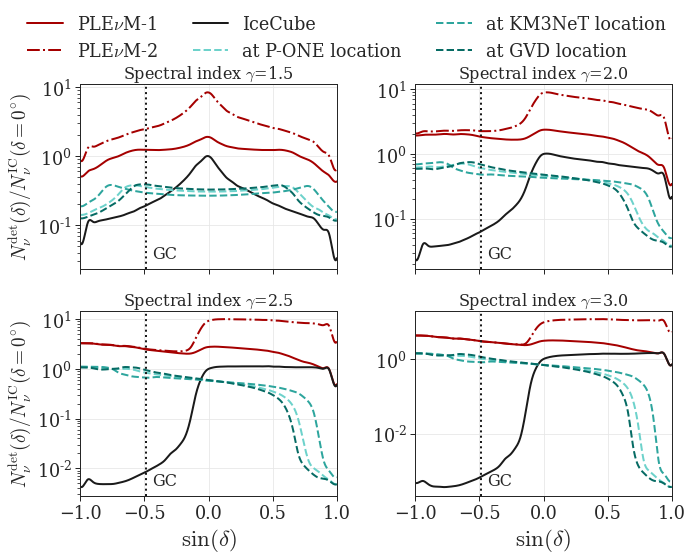

In [14]:
gammas = [1.5, 2.0, 2.5, 3.0]
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(10, 8))
axes = axes.flatten()
for ii, gamma in enumerate(gammas):
    ax = axes[ii]
    # detection efficiency of IceCube for specific spectral index at the horizon
    ## NOTE: maximum detection efficiency changes with spectral index, so we fix this to the horizon here
    arb_max_ic = np.exp(tcks[gamma]["IceCube"](0))
    for det in tcks[gamma]:
        if "Gen" in det:
            continue
        Res = np.exp(tcks[gamma][det](sindec_vals)) / arb_max_ic
        p = ax.plot(
            sindec_vals,
            Res,
            label=poles[det]["label"] if ii == 0 else "",
            color=poles[det]["color"],
            ls=poles[det]["ls"],
            lw=2,
        )
    ax.set_title(r"Spectral index $\gamma$={0:.1f}".format(gamma), fontsize="small")
    ax.axvline(np.sin(sgr_a.icrs.dec), color="k", ls=":")
    # ax.axvline(np.sin(txs0506.icrs.dec), color="k", ls=":")
    ax.set_yscale("log")
    ax.set_xlim(-1, 1)
    ax.text(0.28, 0.055, "GC", transform=ax.transAxes, fontsize="small")

axes[2].set_xlabel(r"$\sin(\delta)$", fontsize="large")
axes[3].set_xlabel(r"$\sin(\delta)$", fontsize="large")
axes[0].set_ylabel(r"$N_{\nu}^{\rm det}(\delta) / N_{\nu}^{\rm IC}(\delta=0^{\circ})$")
axes[2].set_ylabel(r"$N_{\nu}^{\rm det}(\delta) / N_{\nu}^{\rm IC}(\delta=0^{\circ})$")
fig.legend(
    loc="upper center",
    ncol=3,
    frameon=False,
)
fig.tight_layout()
plt.subplots_adjust(top=0.85)
fig.savefig("../plots/relative_detection_eff_d0_vs_sindec.pdf")


# Get the detection efficiency from each telescope in (ra,dec) for one time stamp and integrated

(repeat calculation from `alternative_plenum_aeff.ipynb`, but omit integral over RA)

In [10]:
with open(join(BASEPATH, "resources/rel_events_ra_dec.pckl"), "rb") as f:
    rel_events_ra_dec, ra_vals, dec_vals = pickle.load(f)

with open(join(BASEPATH, "resources/inst_rel_events_ra_dec.pckl"), "rb") as f:
    inst_rel_events_ra_dec, ra_vals, dec_vals = pickle.load(f)


### instantaneous field of view

In [16]:
from matplotlib.colors import ListedColormap


In [17]:
cmap = ListedColormap(sns.color_palette("mako", n_colors=24)[9:])


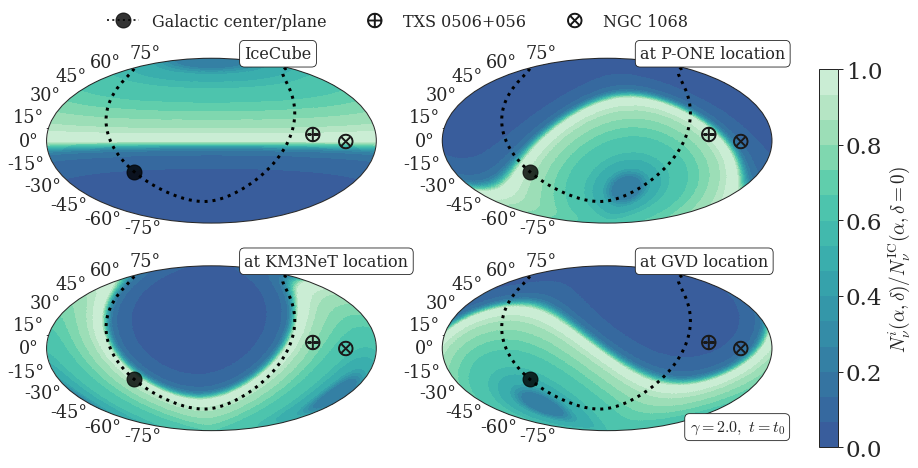

In [18]:
fig = plt.figure(figsize=(13, 7))
n2ind = {"IceCube": 221, "P-ONE": 222, "KM3NeT": 223, "Baikal-GVD": 224}
gamma = 2.0
make_legend = True
for i, (name, vals) in enumerate(inst_rel_events_ra_dec[gamma].items()):
    if "Plenum" in name or name == "Gen-2":
        continue
    ax = fig.add_subplot(n2ind[name], projection="hammer", rasterized=True)
    cax = ax.pcolormesh(ra_vals - np.pi, dec_vals, vals, vmin=0, vmax=1, cmap=cmap)
    # add the galactic center and plane
    if make_legend:
        add_plane(ax, color="black")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k")
        make_legend = False
    else:
        add_plane(ax, color="black", label="__None__")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k", label="__None__")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k", label="__None__")
    ax.text(
        0.6,
        1.0,
        poles[name]["label"],
        fontsize="small",
        transform=ax.transAxes,
        bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
    )
ax.text(
    0.75,
    0,
    rf"$\gamma={gamma},~t=t_0$",
    transform=ax.transAxes,
    fontsize="small",
    bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
)
fig.legend(
    fontsize="small",
    loc="lower center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 0.9),
)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(
    rf"$N_{{\nu}}^{{i}}(\alpha, \delta) / N_{{\nu}}^{{\rm IC}}(\alpha, \delta=0)$"
)
cbar.ax.tick_params(labelsize="large")
fig.savefig("../plots/skymaps_local_time.pdf", bbox_inches="tight")


## only p-one for different times to show rotation

In [19]:
from tools import add_plane


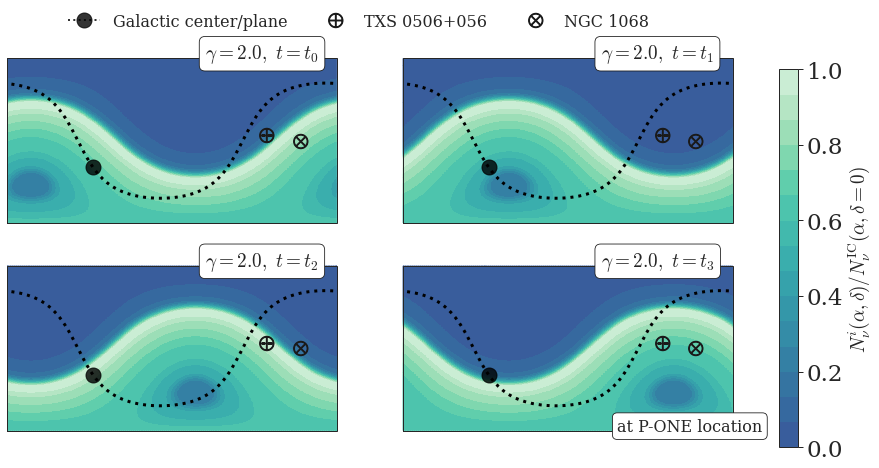

In [20]:
fig, axes = plt.subplots(
    2, 2, figsize=(13, 7), subplot_kw=dict(projection=ccrs.PlateCarree())
)
gamma = 2.0
make_legend = True
name = "P-ONE"
vals = inst_rel_events_ra_dec[gamma][name]
for i, clon in enumerate([0, 90, 180, 270]):
    ax = axes.flatten()[i]
    cax = ax.pcolormesh(
        np.rad2deg(ra_vals),
        np.rad2deg(dec_vals),
        vals,
        vmin=0,
        vmax=1,
        cmap=cmap,
        transform=ccrs.PlateCarree(central_longitude=clon),
    )
    if make_legend:
        add_plane(ax, color="black", transform=ccrs.PlateCarree())
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k", transform=ccrs.PlateCarree())
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k", transform=ccrs.PlateCarree())
        make_legend = False
    else:
        add_plane(ax, color="black", label="__None__", transform=ccrs.PlateCarree())
        add_obj(
            ax,
            "txs",
            marker=r"$\bigoplus$",
            c="k",
            label="__None__",
            transform=ccrs.PlateCarree(),
        )
        add_obj(
            ax,
            "ngc",
            marker=r"$\bigotimes$",
            c="k",
            label="__None__",
            transform=ccrs.PlateCarree(),
        )
    ax.text(
        0.6,
        1.0,
        rf"$\gamma={gamma},~t=t_{i}$",
        fontsize="medium",
        transform=ax.transAxes,
        bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
    )
ax.text(
    0.65,
    0,
    poles[name]["label"],
    transform=ax.transAxes,
    fontsize="small",
    bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
)
fig.legend(
    fontsize="small",
    loc="lower center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 0.9),
)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(
    rf"$N_{{\nu}}^{{i}}(\alpha, \delta) / N_{{\nu}}^{{\rm IC}}(\alpha, \delta=0)$"
)
cbar.ax.tick_params(labelsize="large")
# fig.savefig('../plots/skymaps_local_time.pdf', bbox_inches="tight")


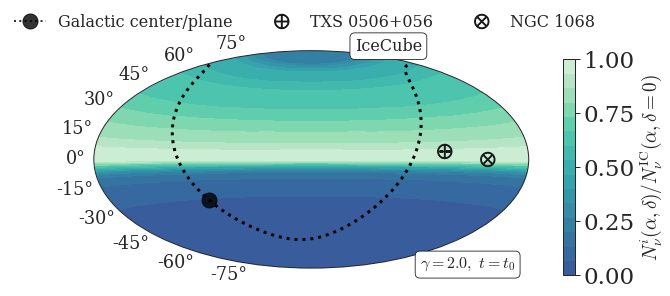

In [21]:
fig = plt.figure(figsize=(8, 4))
n2ind = {"IceCube": 111}
gamma = 2.0
make_legend = True
for i, (name, vals) in enumerate(inst_rel_events_ra_dec[gamma].items()):
    if name != "IceCube":
        continue
    ax = fig.add_subplot(n2ind[name], projection="hammer", rasterized=True)
    cax = ax.pcolormesh(ra_vals - np.pi, dec_vals, vals, vmin=0, vmax=1, cmap=cmap)
    # add the galactic center and plane
    if make_legend:
        add_plane(ax, color="black")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k")
        make_legend = False
    else:
        add_plane(ax, color="black", label="__None__")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k", label="__None__")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k", label="__None__")
    ax.text(
        0.6,
        1.0,
        poles[name]["label"],
        fontsize="small",
        transform=ax.transAxes,
        bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
    )
ax.text(
    0.75,
    0,
    rf"$\gamma={gamma},~t=t_0$",
    transform=ax.transAxes,
    fontsize="small",
    bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
)
fig.legend(
    fontsize="small",
    loc="lower center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 0.9),
)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(
    rf"$N_{{\nu}}^{{i}}(\alpha, \delta) / N_{{\nu}}^{{\rm IC}}(\alpha, \delta=0)$"
)
cbar.ax.tick_params(labelsize="large")


## time integrated

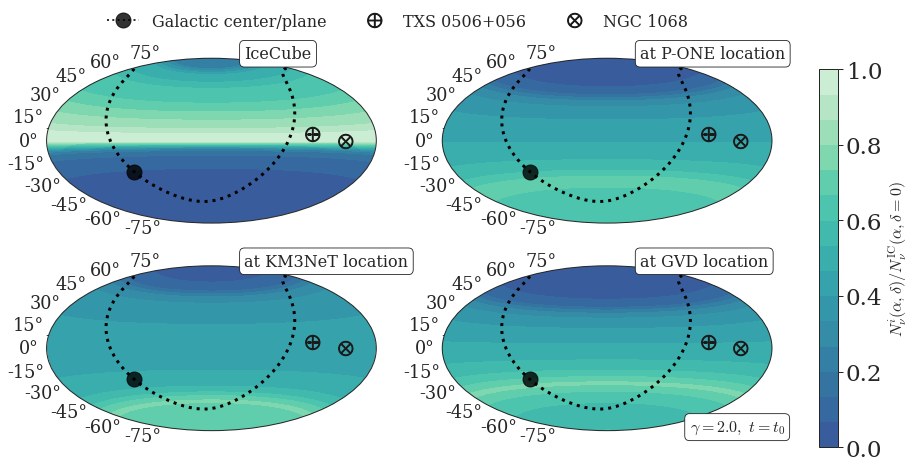

In [22]:
fig = plt.figure(figsize=(13, 7))
n2ind = {"IceCube": 221, "P-ONE": 222, "KM3NeT": 223, "Baikal-GVD": 224}
gamma = 2.0
make_legend = True
for i, (name, vals) in enumerate(rel_events_ra_dec[gamma].items()):
    if "Plenum" in name or name == "Gen-2":
        continue
    ax = fig.add_subplot(n2ind[name], projection="hammer", rasterized=True)
    cax = ax.pcolormesh(ra_vals - np.pi, dec_vals, vals, vmin=0, vmax=1, cmap=cmap)
    # add the galactic center and plane
    if make_legend:
        add_plane(ax, color="black")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k")
        make_legend = False
    else:
        add_plane(ax, color="black", label="__None__")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k", label="__None__")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k", label="__None__")
    ax.text(
        0.6,
        1.0,
        poles[name]["label"],
        fontsize="small",
        transform=ax.transAxes,
        bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
    )
ax.text(
    0.75,
    0,
    rf"$\gamma={gamma},~t=t_0$",
    transform=ax.transAxes,
    fontsize="small",
    bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
)
fig.legend(
    fontsize="small",
    loc="lower center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 0.9),
)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(
    rf"$N_{{\nu}}^{{i}}(\alpha, \delta) / N_{{\nu}}^{{\rm IC}}(\alpha, \delta=0)$",
    fontsize="small",
)
cbar.ax.tick_params(labelsize="large")
fig.savefig("../plots/skymaps_time_integrated.pdf", bbox_inches="tight")


### integrated field of view with (-5°,30°) band, IceCube HESE events and catalog

In [7]:
from tools import _trans


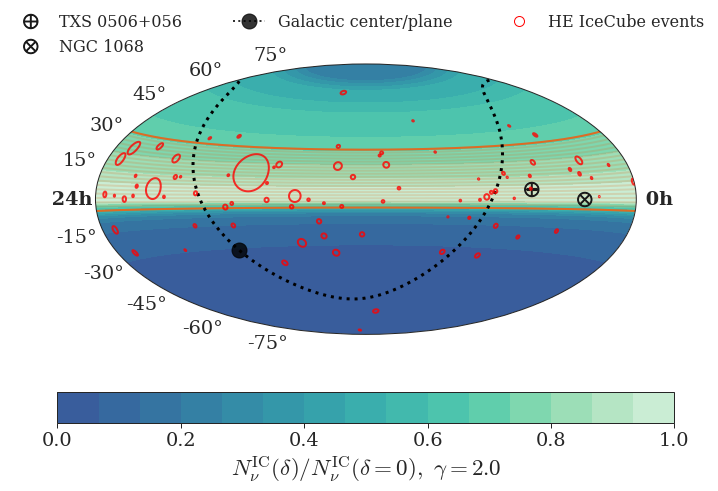

In [24]:
num = len(ra_vals)
for gamma in [2.0]:
    fig = plt.figure(figsize=(10, 7.0))
    ax = fig.add_subplot(111, projection="hammer", rasterized=True)
    cax = ax.pcolormesh(
        ra_vals - np.pi,
        dec_vals,
        rel_events_ra_dec[gamma]["IceCube"],
        vmin=0,
        vmax=1,
        cmap=cmap,
    )
    cbar = fig.colorbar(cax, orientation="horizontal")
    cbar.set_label(
        rf"$N_{{\nu}}^{{\rm IC}}(\delta) / N_{{\nu}}^{{\rm IC}}(\delta=0),~\gamma={gamma}$",
        fontsize="large",
    )
    cbar.ax.tick_params(labelsize="medium")
    # ---------------------------------------
    # show the IceCube lines between -5 and 30 deg
    # ---------------------------------------
    c = "#DC6C25"
    y1 = np.tile(np.radians(-5.0), num)
    y2 = np.tile(np.radians(30), num)

    _x, _y1 = _trans(ra_vals, y1)
    _x, _y2 = _trans(ra_vals, y2)
    ind = np.argsort(_x)
    ax.plot(_x[ind], _y1[ind], color=c)
    ax.plot(_x[ind], _y2[ind], color=c)

    for y_i in np.linspace(-5, 30, num=20, endpoint=True):
        ytmp = np.tile(y_i, len(ra_vals))
        _x2, _y2 = _trans(ra_vals, np.radians(ytmp))
        ind = np.argsort(_x2)
        ax.plot(np.sort(_x2), _y2[ind], color=c, alpha=0.2)

    #  add also txs0506 and NGC1068
    add_obj(ax, "txs", marker=r"$\bigoplus$", c="k")  # DC6C25
    add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k")  # DC6C25

    # add event with error radius
    for i, (rai, deci, si) in enumerate(
        zip(tracks["ra"], tracks["dec"], tracks["sigma"])
    ):
        c = "red"
        if i == 0:
            res = add_event(
                ax,
                ra_i=np.radians(rai),
                dec_i=np.radians(deci),
                sigma_i=np.radians(si),
                labels=["IceCube HE events"],
                color=c,
                linewidths=2.0,
                zorder=10,
            )
        else:
            add_event(
                ax,
                ra_i=np.radians(rai),
                dec_i=np.radians(deci),
                sigma_i=np.radians(si),
                color=c,
                linewidths=2.0,
                zorder=10,
            )

    # fix the labels
    set_ticks(ax, fs="medium")
    # add the galactic center and plane
    add_plane(ax, color="black")

    # get all legend entries and add the circle for the HE events
    handles, labels = ax.get_legend_handles_labels()
    HE_events = Line2D(
        range(1),
        range(1),
        color="red",
        marker="o",
        markersize=10,
        markerfacecolor="None",
        linewidth=0,
        label="HE IceCube events",
    )
    handles.append(HE_events)
    fig.legend(handles=handles, fontsize="small", mode="expand", ncol=3, frameon=False)

    fig.tight_layout()
    plt.subplots_adjust(top=0.87)  # , bottom=0.2)
    fig.savefig(
        f"../plots/IceCube_Skymap_horizon_gamma{int(np.round(gamma*10))}.pdf",
        bbox_inches="tight",
        dpi=200,
    )
    plt.show()


# Show a skymap with 4 time snippets of the best field of view of view of all existing telescopes

### IceCube only, all day, every day 

In [17]:
### need cartopy for the following plots!
num = 500
y1 = np.tile(np.radians(-5.0), num)
y2 = np.tile(np.radians(30), num)

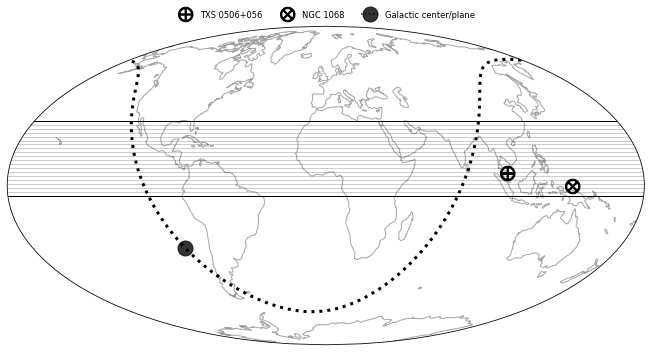

In [18]:
if ccrs:
    f, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(projection=ccrs.Mollweide()))
    ax.set_global()
    ax.coastlines(color="gray", alpha=0.7)

    ax.plot(
        np.rad2deg(ra_vals),
        np.rad2deg(y1),
        color=poles["IceCube"]["color"],
        transform=ccrs.PlateCarree(),
        lw=1,
    )
    ax.plot(
        np.rad2deg(ra_vals),
        np.rad2deg(y2),
        color=poles["IceCube"]["color"],
        transform=ccrs.PlateCarree(),
        lw=1,
    )

    for y_i in np.linspace(-5, 30, num=20, endpoint=True):
        y_loc = np.tile(y_i, len(ra_vals))
        ax.plot(
            np.rad2deg(ra_vals),
            y_loc,
            color=poles["IceCube"]["color"],
            alpha=0.2,
            transform=ccrs.PlateCarree(),
            lw=1,
        )
    add_obj(
        ax, "txs", marker=r"$\bigoplus$", c="k", transform=ccrs.PlateCarree()
    )  # DC6C25
    add_obj(
        ax, "ngc", marker=r"$\bigotimes$", c="k", transform=ccrs.PlateCarree()
    )  # DC6C25
    add_plane(ax, color="black", transform=ccrs.PlateCarree())
    ax.legend(
        fontsize="small",
        loc="lower center",
        ncol=3,
        frameon=False,
        bbox_to_anchor=(0.5, 1.0),
    )
    f.tight_layout()
else:
    f, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(projection="aitoff"))
    ax.plot(ra_vals - np.pi, y1, color=poles["IceCube"]["color"], lw=1)
    ax.plot(ra_vals - np.pi, y2, color=poles["IceCube"]["color"], lw=1)
    for y_i in np.deg2rad(np.linspace(-5, 30, num=20, endpoint=True)):
        y_loc = np.tile(y_i, len(ra_vals))
        ax.plot(
            ra_vals - np.pi, y_loc, color=poles["IceCube"]["color"], alpha=0.2, lw=1
        )
    add_obj(ax, "txs", marker=r"$\bigoplus$", c="k")  # DC6C25
    add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k")  # DC6C25
    add_plane(ax, color="black")
    ax.legend(
        fontsize="small",
        loc="lower center",
        ncol=3,
        frameon=False,
        bbox_to_anchor=(0.5, 1.0),
    )
    f.tight_layout()


IceCube
P-ONE
KM3NeT
Baikal-GVD


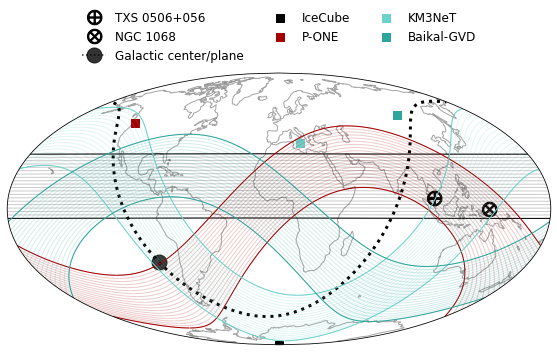

IceCube
P-ONE
KM3NeT
Baikal-GVD


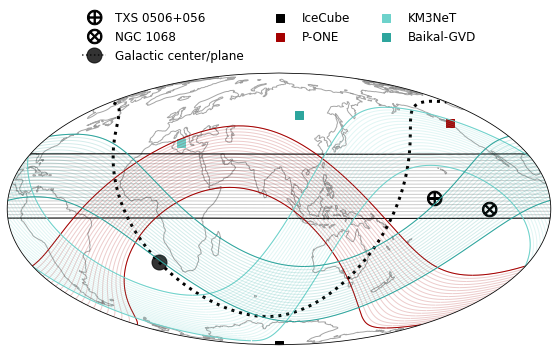

IceCube
P-ONE
KM3NeT
Baikal-GVD


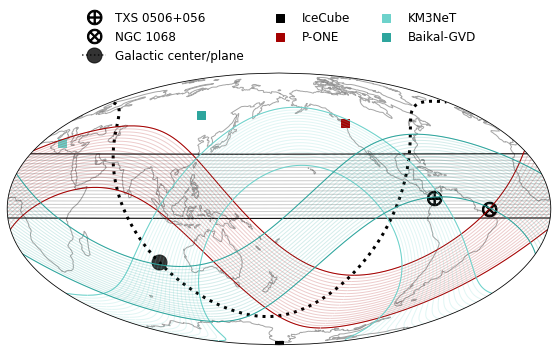

IceCube
P-ONE
KM3NeT
Baikal-GVD


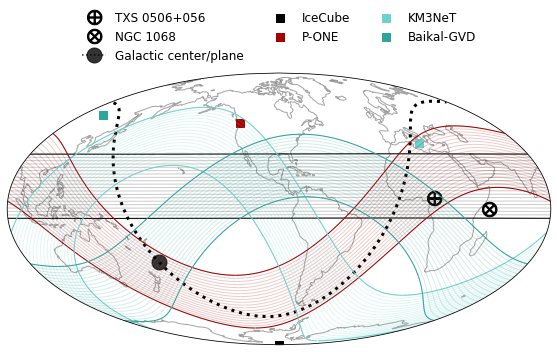

IceCube
P-ONE
KM3NeT
Baikal-GVD


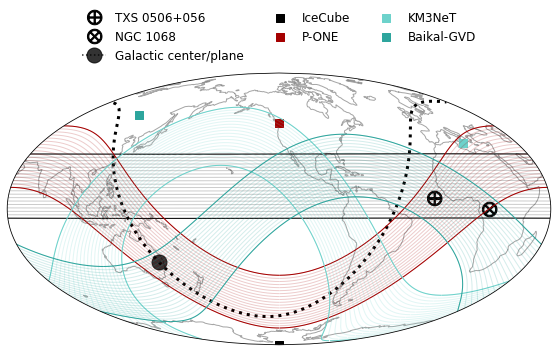

In [23]:
# loop through daily rotations
if ccrs:
    for ii, clon in enumerate([0, 90, 180, 270, poles["P-ONE"]["lon"].value]):
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(projection=ccrs.Mollweide(central_longitude=clon))
        ax.set_global()
        ax.coastlines(color="gray", alpha=0.7)

        # coordinate grid in equatorial coordinates (icrs)
        # these will be the integration coordinates
        eq_coords_low = SkyCoord(ra_vals * u.radian, -y1 * u.radian, frame="icrs")
        eq_coords_up = SkyCoord(ra_vals * u.radian, -y2 * u.radian, frame="icrs")

        ic_loc = EarthLocation(
            lat=poles["IceCube"]["lat"],
            lon=poles["IceCube"]["lon"],
        )

        add_obj(
            ax,
            "txs",
            marker=r"$\bigoplus$",
            c="k",
            transform=ccrs.PlateCarree(central_longitude=clon),
        )  # DC6C25
        add_obj(
            ax,
            "ngc",
            marker=r"$\bigotimes$",
            c="k",
            transform=ccrs.PlateCarree(central_longitude=clon),
        )  # DC6C25
        add_plane(ax, color="black", transform=ccrs.PlateCarree(central_longitude=clon))

        # loop over detectors
        for i, (k, coord) in enumerate(poles.items()):
            if "Plenum" in k or k == "Gen-2":
                continue
            print(k)
            # local detector
            loc = EarthLocation(
                lat=coord["lat"],
                lon=coord["lon"],
            )
            time = Time("2021-4-20 00:00:00", scale="utc")
            # transform integration coordinates to local frame
            local_coords_low = eq_coords_low.transform_to(
                AltAz(obstime=time, location=loc)
            )
            local_coords_up = eq_coords_up.transform_to(
                AltAz(obstime=time, location=loc)
            )

            ind = np.argsort(local_coords_low.az.deg)
            ax.plot(
                local_coords_low.az.deg[ind] + loc.lon.deg,
                local_coords_low.alt.deg[ind],
                transform=ccrs.PlateCarree(),
                lw=1,
                color=coord["color"],
            )
            ax.plot(
                local_coords_up.az.deg[ind] + loc.lon.deg,
                local_coords_up.alt.deg[ind],
                transform=ccrs.PlateCarree(),
                lw=1,
                color=coord["color"],
            )
            ax.scatter(
                loc.lon.deg,
                loc.lat.deg,
                color=coord["color"],
                marker="s",
                s=50,
                transform=ccrs.PlateCarree(),
                label=k,
            )

            for y_i in np.linspace(-30, 5, num=20, endpoint=True):
                y_loc = np.tile(y_i, len(ra_vals))
                local_coords_tmp = SkyCoord(
                    ra_vals * u.radian, y_loc * u.degree, frame="icrs"
                ).transform_to(AltAz(obstime=time, location=loc))
                ind = np.argsort(local_coords_tmp.az.deg)
                ax.plot(
                    local_coords_tmp.az[ind].deg + loc.lon.deg,
                    local_coords_tmp.alt.deg[ind],
                    transform=ccrs.PlateCarree(),
                    lw=1,
                    color=coord["color"],
                    alpha=0.2,
                )
            ax.legend(
                fontsize="large",
                loc="lower center",
                ncol=3,
                frameon=False,
                bbox_to_anchor=(0.5, 1.0),
            )
            fig.tight_layout()
            fig.savefig(join(BASEPATH, f"plots/best_field_of_view_map_{ii}.png"))
        plt.show()
else:
    print("Cant make these plots without cartopy, sorry :(")


# Plenum improvements in discovery potential for gamma=2 and the same amount of time

This plot shows a direct comparison of plenum and IceCube for equal run times

### Idea:
* Discovery potential improvement:

$R = \frac{\Phi_0}{\Phi_{\rm new}} = \left( \frac{t_0}{t_{\rm new}} \right)^{-0.8} = \left( \frac{t_{\rm new}}{t_0} \right)^{0.8} = \left( \frac{\int dE \cdot A_{\rm eff, new} \cdot d\Phi/dE}{\int dE A_{\rm eff, 0} \cdot d\Phi/dE} \right)^{0.8}$

* Improvement relative to IceCube at horizon $(\delta=0)$:

$R_0 = \left( \frac{\int dE \cdot A_{\rm eff, new}(\delta) \cdot d\Phi/dE}{\int dE \cdot A_{\rm eff, IC}(\delta=0) \cdot d\Phi/dE} \right)^{0.8}$

* Improvement relative to IceCube at resp. declination:

$R_{rel} = \left( \frac{\int dE \cdot A_{\rm eff, new}(\delta) \cdot d\Phi/dE}{\int dE \cdot A_{\rm eff, IC}(\delta) \cdot d\Phi/dE} \right)^{0.8}$

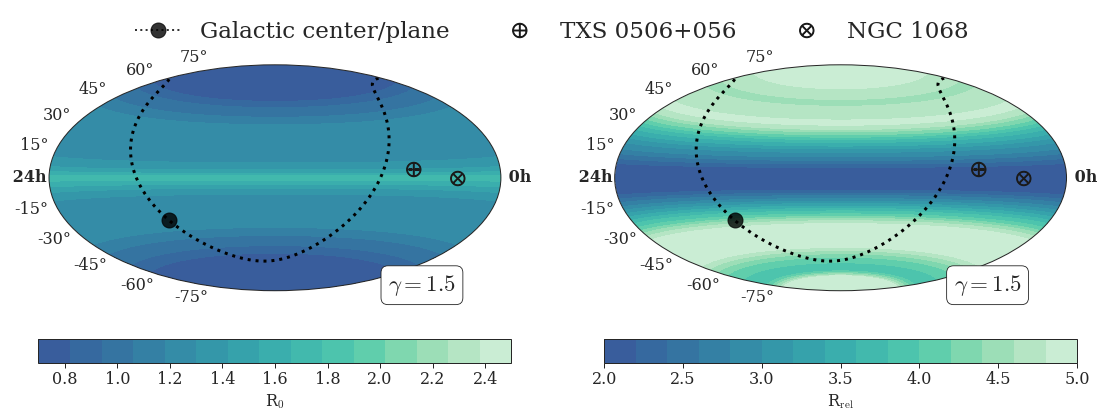

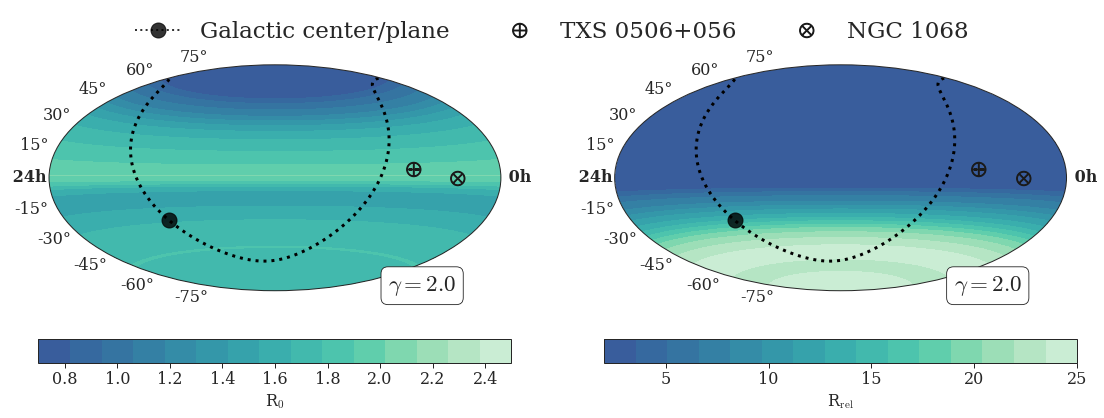

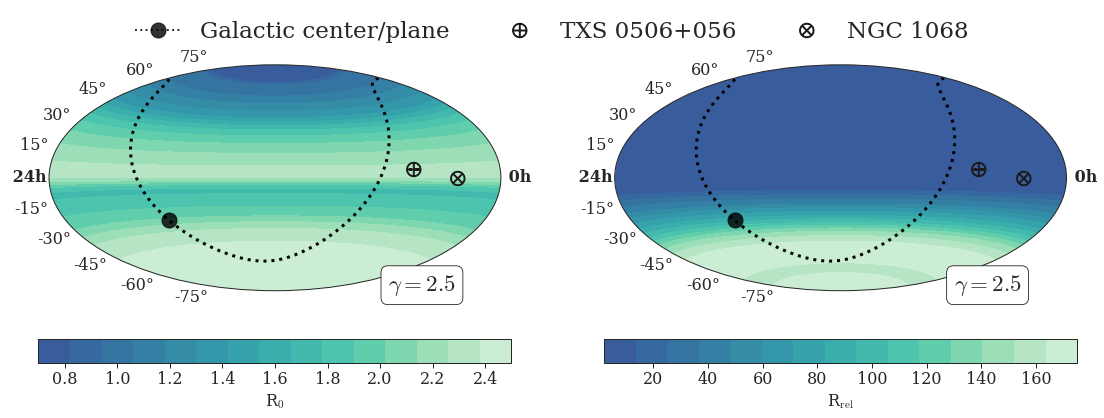

In [28]:
i2ind = {0: 121, 1: 122}
# Options:
# R0: comparison to IceCube at horizon
# R_rel: comparison to IceCube at respective declination
variation = ["r0", "rrel"]
labels = {"r0": r"R$_0$", "rrel": r"R$_{\mathrm{rel}}$"}
# min, max for colorbar, because there are some numeric hiccups at the poles
extreme = {
    1.5: {"r0": (0.7, 2.5), "rrel": (2.0, 5.0)},
    2.0: {"r0": (0.7, 2.5), "rrel": (2.0, 25.0)},
    2.5: {"r0": (0.7, 2.5), "rrel": (2.0, 175.0)},
}

for gamma in [1.5, 2.0, 2.5]:
    fig = plt.figure(figsize=(16, 6))
    for i, vari in enumerate(variation):
        ax = fig.add_subplot(i2ind[i], projection="hammer", rasterized=True)
        comb_vals = np.zeros_like(rel_events_ra_dec[gamma]["IceCube"])

        if vari == "rrel":
            mask = rel_events_ra_dec[gamma]["IceCube"] > 0.0
            comb_vals[mask] = (
                rel_events_ra_dec[gamma]["Plenum-1"][mask]
                / rel_events_ra_dec[gamma]["IceCube"][mask]
            ) ** 0.8
        else:
            comb_vals = (
                rel_events_ra_dec[gamma]["Plenum-1"]
                / rel_events_ra_dec[gamma]["IceCube"][
                    len(rel_events_ra_dec[gamma]["IceCube"]) // 2
                ]
            ) ** 0.8
        _min, _max = extreme[gamma][vari]

        cax = ax.pcolormesh(
            ra_vals - np.pi, dec_vals, comb_vals, vmin=_min, vmax=_max, cmap=cmap
        )

        cbar = fig.colorbar(cax, orientation="horizontal")
        cbar.ax.tick_params(labelsize="small")
        cbar.set_label(labels[vari], fontsize="small")
        set_ticks(ax, fs="small")
        # add the galactic center and plane
        if i == 0:
            add_plane(ax, color="black")
            add_obj(ax, "txs", marker=r"$\bigoplus$", c="k")
            add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k")
        else:
            add_plane(ax, color="black", label="__None__")
            add_obj(ax, "txs", marker=r"$\bigoplus$", c="k", label="__None__")
            add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k", label="__None__")
        ax.text(
            0.75,
            0,
            rf"$\gamma={gamma}$",
            transform=ax.transAxes,
            fontsize="large",
            bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
        )

    fig.legend(
        fontsize="large", loc="upper center", ncol=4, frameon=False
    )  # ,  mode='expand')
    fig.tight_layout()
    plt.subplots_adjust(top=0.84)  # , bottom=0.2)


# Show the time evolution of plenum

----

This plot will show how plenum improves (after x years) the total discovery potential if we turn it on after 10years of IceCube 

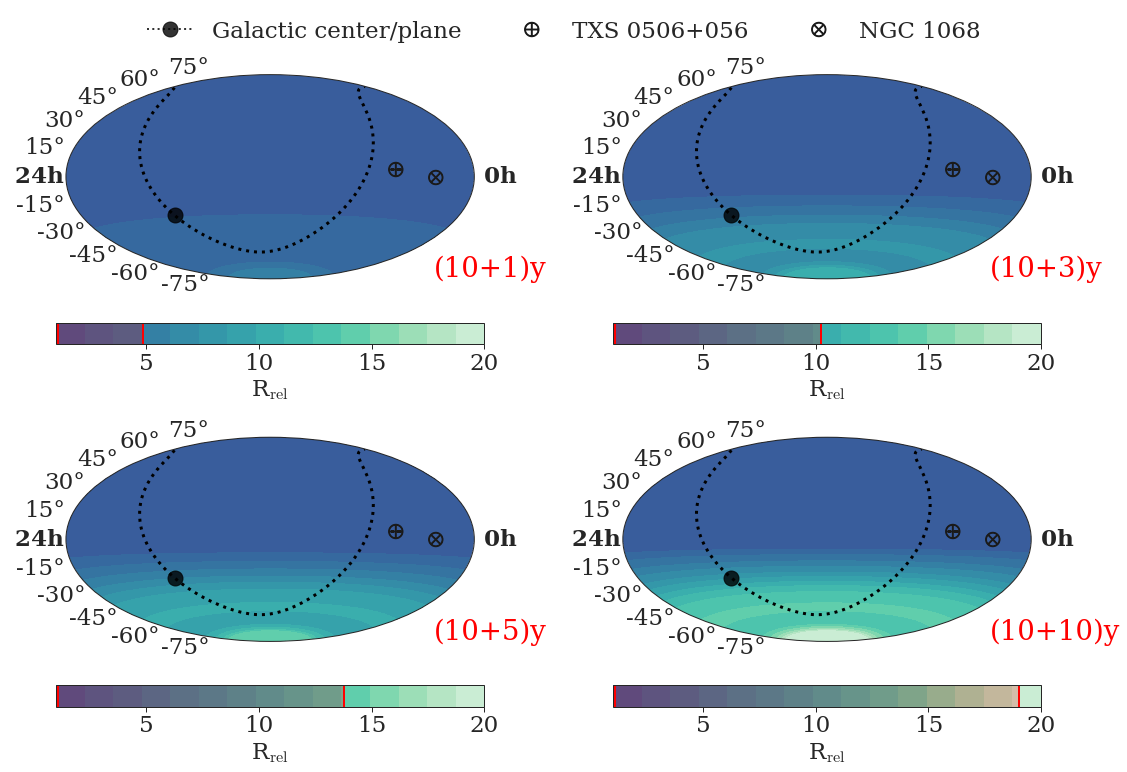

In [29]:
i2ind = {0: 221, 1: 222, 2: 223, 3: 224}
# Options:
# R0: comparison to IceCube at horizon
# R_rel: comparison to IceCube at respective declination
variation = ["r0", "rrel"]
labels = {"r0": r"R$_0$", "rrel": r"R$_{\mathrm{rel}}$"}
# min, max for colorbar, because there are some numeric hiccups at the poles
extreme = {1.0: (1.0, 20.0), 3.0: (1.0, 20.0), 5.0: (1.0, 20.0), 10.0: (1.0, 20.0)}
t_0 = 10.0  # years
t_news = [1.0, 3.0, 5.0, 10.0]  # years
gamma = 2.0
fig = plt.figure(figsize=(16, 11))
vari = "rrel"

for i, t_new in enumerate(t_news):
    comb_vals = np.zeros_like(rel_events_ra_dec[gamma]["IceCube"])
    ax = fig.add_subplot(i2ind[i], projection="hammer", rasterized=True)

    mask = rel_events_ra_dec[gamma]["IceCube"] > 0.0
    comb_vals[mask] = (
        rel_events_ra_dec[gamma]["Plenum-1"][mask]
        / rel_events_ra_dec[gamma]["IceCube"][mask]
        * t_new
        / (t_0 + t_new)
    ) ** 0.8
    _min, _max = extreme[t_new]
    cax = ax.pcolormesh(
        ra_vals - np.pi, dec_vals, comb_vals, vmin=_min, vmax=_max, cmap=cmap
    )
    cbar = fig.colorbar(cax, orientation="horizontal")
    cbar.ax.tick_params(labelsize="large")
    cbar.set_label(labels[vari], fontsize="large")

    cmarker_0 = _min + 0.005 * (_max - _min)
    cmarker_1 = np.max(comb_vals)
    cbar.ax.axvline(cmarker_0, color="red", lw=2)
    cbar.ax.axvline(cmarker_1, color="red", lw=2)
    # I have no idea how fill_between works for color axes :D
    cbar.ax.fill_between(
        [cmarker_0, cmarker_1], [-1, -1], [50, 50], color="red", alpha=0.2
    )

    set_ticks(ax, fs="large")
    # add the galactic center and plane
    if i == 0:
        add_plane(ax, color="black")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k")
    else:
        add_plane(ax, color="black", label="__None__")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k", label="__None__")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k", label="__None__")
    ax.text(
        0.9,
        0.01,
        r"({1:d}+{0:d})y".format(int(t_new), int(t_0)),
        ha="left",
        size="x-large",
        transform=ax.transAxes,
        color="red",
    )

fig.legend(
    fontsize="large", loc="upper center", ncol=4, frameon=False
)  # ,  mode='expand')
fig.tight_layout()
plt.subplots_adjust(top=0.9)  # , bottom=0.2)


# Show ratio including Gen2 

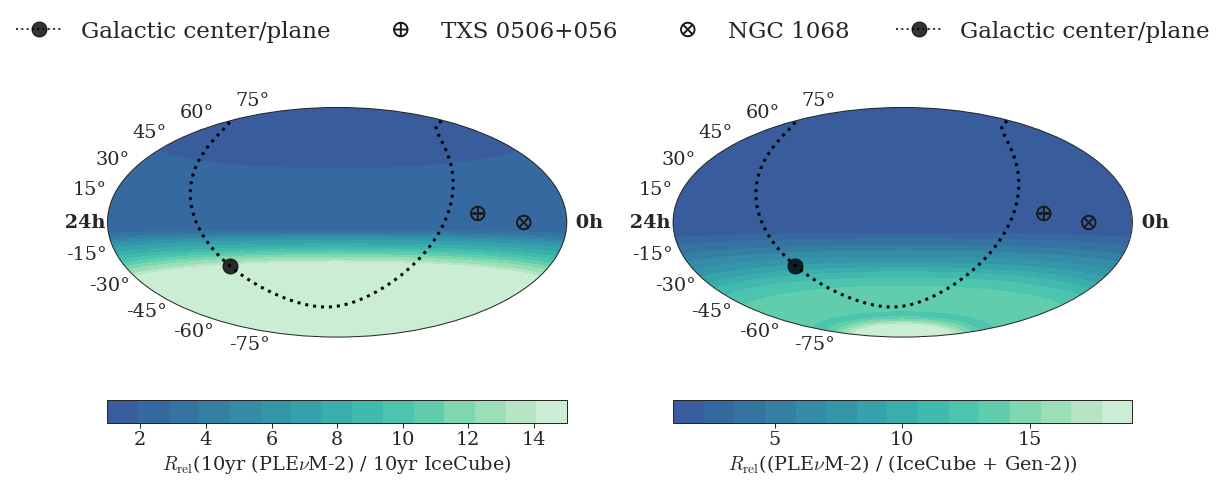

In [30]:
gamma = 2.0
fig = plt.figure(figsize=(16, 7))
vari = "rrel"
_min, _max = (1.0, 15.0)

comb_vals = np.zeros_like(rel_events_ra_dec[gamma]["IceCube"])
mask = rel_events_ra_dec[gamma]["IceCube"] > 0.0

ax = fig.add_subplot(121, projection="hammer", rasterized=True)
## 10yrs of Plenum including Gen-2 (subtracting IceCube events from original Plenum events)
## vs 20yrs of IceCube
comb_vals[mask] = (
    (rel_events_ra_dec[gamma]["Plenum-2"][mask])
    / rel_events_ra_dec[gamma]["IceCube"][mask]
) ** 0.8
cax = ax.pcolormesh(
    ra_vals - np.pi, dec_vals, comb_vals, vmin=_min, vmax=_max, cmap=cmap
)
cbar = fig.colorbar(cax, orientation="horizontal")
cbar.ax.tick_params(labelsize="medium")
cbar.set_label(
    r"$R_{\mathrm{rel}}$(10yr (PLE$\nu$M-2) / 10yr IceCube)", fontsize="medium"
)

set_ticks(ax, fs="medium")
# add the galactic center and plane
add_plane(ax, color="black")
add_obj(ax, "txs", marker=r"$\bigoplus$", c="k")
add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k")

comb_vals = np.zeros_like(rel_events_ra_dec[gamma]["IceCube"])
mask = rel_events_ra_dec[gamma]["IceCube"] > 0.0
ax = fig.add_subplot(122, projection="hammer", rasterized=True)
## 10yrs of Plenum including Gen-2 (subtracting IceCube events from original Plenum events)
## vs 10yrs of IceCube plus 10yrs of Gen2
comb_vals[mask] = (
    (rel_events_ra_dec[gamma]["Plenum-2"][mask])
    / (
        rel_events_ra_dec[gamma]["IceCube"][mask]
        + rel_events_ra_dec[gamma]["Gen-2"][mask]
    )
) ** 0.8
cax = ax.pcolormesh(
    ra_vals - np.pi, dec_vals, comb_vals, vmin=_min, cmap=cmap  # vmax=_max,
)
cbar = fig.colorbar(cax, orientation="horizontal")
cbar.ax.tick_params(labelsize="medium")
cbar.set_label(
    r"$R_{\mathrm{rel}}$((PLE$\nu$M-2) / (IceCube + Gen-2))", fontsize="medium"
)

set_ticks(ax, fs="medium")
# add the galactic center and plane
add_plane(ax, color="black")
add_obj(ax, "txs", marker=r"$\bigoplus$", c="k", label="__None__")
add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k", label="__None__")

fig.legend(
    fontsize="large", loc="upper center", ncol=4, frameon=False
)  # ,  mode='expand')
fig.tight_layout()
plt.subplots_adjust(top=0.9)  # , bottom=0.2)
